## SCRIMP: Partitioned Finite Element Method (PFEM) for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous wave equation

### <b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of the Partitioned Finite Element Method (PFEM) to discretize a port-Hamiltonian system related to the two-dimensional wave equation. We specifically learn how to define the problem inside SCRIMP. This notebook is related to the companion paper "Partitioned Finite Element Method for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous 2D wave equation" by A. Serhani, D. Matignon and G. Haine, (2019). The slides of a corresponding talk is available [here](./serhani_GdT6.pdf). We refer to both paper and slides for the complete description of the discretization.

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline

# Import here the standard Python libraries used in the Notebook
import numpy as np

# Import here the classes related to SCRIMP
from Waves import Wave_2D

# Anisotropic heterogeneous 2D wave equation:


We consider the two-dimensional heterogeneous anisotropic wave equation defined for all $t\ge 0$ as
$$
\begin{array}{ll} 
    \rho(\boldsymbol x)\,\displaystyle \frac{\partial^2}{\partial t^2} w(t,\boldsymbol x) &=& \text{div}\Big(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)\Big), \quad \boldsymbol x \in \Omega, \\
    Z(\boldsymbol x)~(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)) \cdot {\bf{n}} + 
    {\partial_t} w(t,\boldsymbol x) & = & 0, \quad \boldsymbol x \in \partial \Omega, \\ 
    w(0, \boldsymbol x) & = & w_0(x), \quad \boldsymbol x \in \Omega, t=0 \\
    {\partial_t} w(0,\boldsymbol x) & = & w_1(x), \quad \boldsymbol x \in \Omega, t=0, \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 

$w(t,\boldsymbol x)$ denotes the deflection from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$. $\rho \in L^{\infty}(\Omega)$ (positive and bounded from below) denotes the mass density, $\overline{\overline T} \in L^{\infty}(\Omega)^{2\times 2}$ (symmetric and coercive) the Young's elasticity modulus, $Z(\boldsymbol x)$ is the positive impedance function defined on $\partial \Omega$. 


<b>Structure of part A</b>: This notebook first defines the continuous problem by using a specific class of SCRIMP related to the wave equation in two dimensions. Then we tackle the discretization in space of the port-Hamiltonian system through the PFEM methodology. This discretization leads to a ODE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

## Class object related to the PDE wave equation

In [2]:
W = Wave_2D()

## Physical problem

In [3]:
# GEOMETRIC RECTANGULAR DOMAIN
x0, xL = 0, 2
y0, yL = 0, 1
W.Set_Rectangular_Domain(x0, xL, y0, yL)


# TIME INTERVAL
tf = 5
dt = 1e-3
W.Set_Initial_Final_Time(initial_time=0, final_time=tf)


# MASS DENSITY
rho = 'x[0]*x[0] - x[1]*x[1] + 2' 


# YOUNG'S ELASTICITY MODULUS
T11 = 'cos(x[0]*x[1]) + 4' 
T12 = ' x[1]'
T22 = 'abs(x[0]-x[1])+2'  

W.Set_Physical_Parameters(rho, T11, T12, T22)


# DAMPINGS
Z   = '0.1'                                       # impedance

eps = ' 25 * x[0] * (xL-x[0]) * x[1] * (yL-x[1])' # internal damping coefficient

k11 = '(x[0]+x[1]+1)/6'                           #
k12 =  'x[1]/6'                                   # Kelving-Voigt damping
k22 =  'x[0]+ x[1] + 1'                           #
    
W.Set_Damping(damp=['impedance_mbc', 'internal', 'kv'], Rtime_func=None, 
                          Z=Z, eps=eps, k11=k11, k12=k12, k22=k22)

Damping: impedance_mbc,  internal,  kv
Damping: OK
---------------------------------------- 



## Environement setting

In [4]:
# Mixed boundaries declaration
W.Set_Mixed_Boundaries( Dir=['G1'], Nor=['G3'], Imp=['G2', 'G4'])


# Mixed boundary control
# Dirichlet trace as boundary control u_D(t,x) = f0(t)g0(x) + f1(t) + g1(x); u_D'(t,x) = f0'(t)g0(x) + f1'(t) 
W.Set_Mixed_BC_Dirichlet(Ub_tm0=lambda t : 0 * np.sin( 2 * 2*np.pi/tf *t) * 25,
                         Ub_sp0='x[0] * x[1] * (1-x[1])', 
                         Ub_tm0_dir = lambda t : 0)      

#  Normal trace as boundary control u_D(t,x) = f0(t)g0(x) + f1(t) + g1(x)
W.Set_Mixed_BC_Normal(Ub_tm0=lambda t:  np.sin( 2 * 2*np.pi/tf *t) * 25 ,
                      Ub_sp0='x[0] * x[1] * (1-x[1])')   

# Initial datas
Aq_0_1 = '0'
Aq_0_2 = '0'
Ap_0   = '0'
W_0    = '0'




Dirchlet boundary: G1
Normal boundary: G3
Impedance boundary: G2,  G4
Mixed Boundaries: OK
---------------------------------------- 



## Spatial discretization

Mesh: hmax= 0.084 Nv= 753
Mesh: OK
---------------------------------------- 

Vq= RT_0 ,	 Vp= P_1 ,	 Vb= P_1
Nq= 2160 ,	 Np= 753 ,	 Nb= 96
DOFsys= 2913
FE spaces: OK
---------------------------------------- 



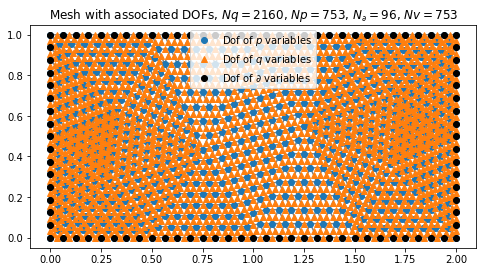

Nb_D= 17 ,	 Nb_N= 15 ,	 Nb_Z= 64
DOFsysDAE= 2930
DAE system: OK
---------------------------------------- 



<Figure size 432x288 with 0 Axes>

In [5]:
# Mesh
W.Set_Gmsh_Mesh('rectangle.xml', rfn_num=3)


# Finite elements spaces
W.Set_Finite_Elements_Spaces(family_q='RT', family_p='P', family_b='P', rq=0, rp=1, rb=1)


# Plot mesh with dofs
W.Plot_Mesh_with_DOFs()


# Assembly
W.Assembly_Mixed_BC()

### Projections

In [6]:
# Project boundary control variables
W.Project_Boundary_Control()


# Project initial datas
W.Set_Initial_Data(Aq_0_1=Aq_0_1, Aq_0_2=Aq_0_2, Ap_0=Ap_0, W_0=W_0)
W.Project_Initial_Data() 

Project BC: OK
Project init data: OK
---------------------------------------- 



### Time integration settings

In [7]:
# Integration method
integration_method = 'DAE:RK4Augmented'


# Time step for 'home-made' methods
dt = 1e-3
W.Set_Time_Setting(time_step=dt, tf=tf)



### Start time-stepping

In [8]:
# Get energy variables and hamiltonian 
Alpha, Hamiltonian = W.Time_Integration(integration_method)

alpha_q = Alpha[:W.Nq, :]
alpha_p = Alpha[W.Nq:, :]

# Get delfelction
w = W.Get_Deflection(Alpha)

Time-stepping RK4Augmented : |## 5%|

KeyboardInterrupt: 

### Post-processing

In [ ]:
# Plot Hamiltonian
W.Plot_Hamiltonian(W.tspan, Hamiltonian, linewidth=5)

In [ ]:
# Trisurf of alpha_p
W.Trisurf(alpha_p, instance=0, title='Linear momentum at t='+str(0))
W.Trisurf(alpha_p, instance=1, title='Linear momentum at t='+str(1))
W.Trisurf(alpha_p, instance=tf, title='Linear momentum at t='+str(tf))

In [ ]:
# Trisurf animation
%matplotlib qt5
W.Moving_Trisurf(alpha_p, step=25, title=r'Linear momentum: $\alpha_p$')

In [ ]:
# Quiver animation
    W.t(alpha_q, step=25, title=r'Strain: $\alpha_q$')